# OpenCV Feature Detection and Matching Workbook

### Imports

In [215]:
import cv2; print(cv2.__version__)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

3.4.2


### Load Images

In [303]:
img1_path = '../data/smash/fox/bair_right.png'
img1 = cv2.imread(img1_path, 0)

img2_path = '../data/leffen_mango_tbh8/image-001130.png'
img2 = cv2.imread(img2_path, 0)

### FLANN

In [448]:
def flann(algorithm, img_kp_des1, img_kp_des2, good_ratio=0.7, min_match_count=10, quiet=False):
    img1, kp1, des1 = img_kp_des1
    img2, kp2, des2 = img_kp_des2
    
    index_params = dict(algorithm=algorithm)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    # https://docs.opencv.org/3.4.2/dc/de2/classcv_1_1FlannBasedMatcher.html
    
    matches = flann.knnMatch(des1, des2, 2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < good_ratio*n.distance:
            good.append(m)

    img_match = img2.copy()
    if len(good) >= min_match_count:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()

        h,w = img1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts, M)

        cv2.polylines(img_match, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

    else:
        if not quiet:
            print("Not enough matches are found - {}/{}".format(len(good), min_match_count))
        matchesMask = None

    draw_params = dict(matchColor=(0,255,0), # draw matches in green color
                       singlePointColor=None,
                       matchesMask=matchesMask, # draw only inliers
                       flags=2)

    img_match = cv2.drawMatches(img1, kp1, img_match, kp2, good, None, **draw_params)
    return img_match, (matchesMask is not None)

### SIFT

In [413]:
sift = cv2.xfeatures2d.SIFT_create(nfeatures=5000, contrastThreshold=0.01, edgeThreshold=20, sigma=1.6)
# https://docs.opencv.org/3.4.2/d5/d3c/classcv_1_1xfeatures2d_1_1SIFT.html

kp1_sift, des1_sift = sift.detectAndCompute(img1, None)
kp2_sift, des2_sift = sift.detectAndCompute(img2, None)

print(len(kp1_sift))
print(len(kp2_sift))

200
3007


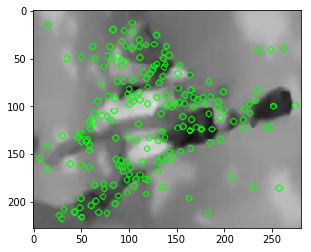

In [414]:
plt.imshow(cv2.drawKeypoints(img1, kp1_sift, None, color=(0,255,0), flags=0)); plt.show()

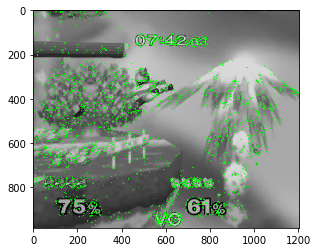

In [415]:
plt.imshow(cv2.drawKeypoints(img2, kp2_sift, None, color=(0,255,0), flags=0)); plt.show()

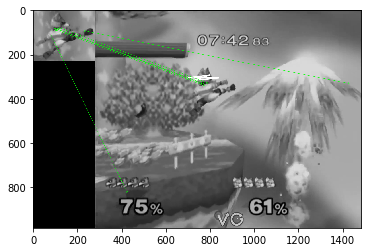

In [416]:
img_flann_sift, is_match = flann(1, (img1, kp1_sift, des1_sift), (img2, kp2_sift, des2_sift))
if is_match:
    plt.imshow(img_flann_sift); plt.show()

### SURF

In [417]:
surf = cv2.xfeatures2d.SURF_create()
# https://docs.opencv.org/3.4.2/d5/df7/classcv_1_1xfeatures2d_1_1SURF.html

kp1_surf, des1_surf = surf.detectAndCompute(img1, None)
kp2_surf, des2_surf = surf.detectAndCompute(img2, None)

print(len(kp1_surf))
print(len(kp2_surf))

158
3195


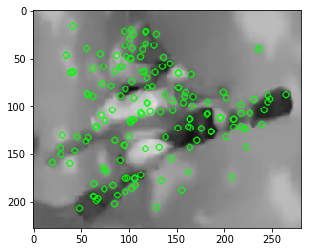

In [418]:
plt.imshow(cv2.drawKeypoints(img1, kp1_surf, None, color=(0,255,0), flags=0)); plt.show()

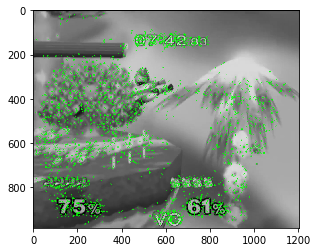

In [419]:
plt.imshow(cv2.drawKeypoints(img2, kp2_surf, None, color=(0,255,0), flags=0)); plt.show()

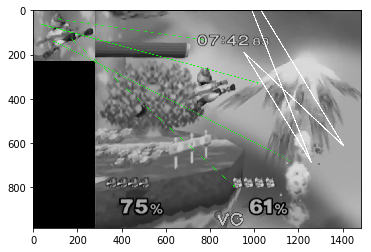

In [420]:
img_flann_surf, is_match = flann(1, (img1, kp1_surf, des1_surf), (img2, kp2_surf, des2_surf))
if is_match:
    plt.imshow(img_flann_surf); plt.show()

### ORB

In [421]:
orb = cv2.ORB_create(5000, edgeThreshold=5)
# https://docs.opencv.org/3.4.2/db/d95/classcv_1_1ORB.html

kp1_orb, des1_orb = orb.detectAndCompute(img1, None)
kp2_orb, des2_orb = orb.detectAndCompute(img2, None)

print(len(kp1_orb))
print(len(kp2_orb))

457
4680


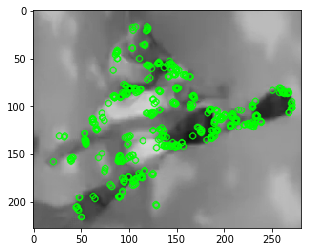

In [422]:
plt.imshow(cv2.drawKeypoints(img1, kp1_orb, None, color=(0,255,0), flags=0)); plt.show()

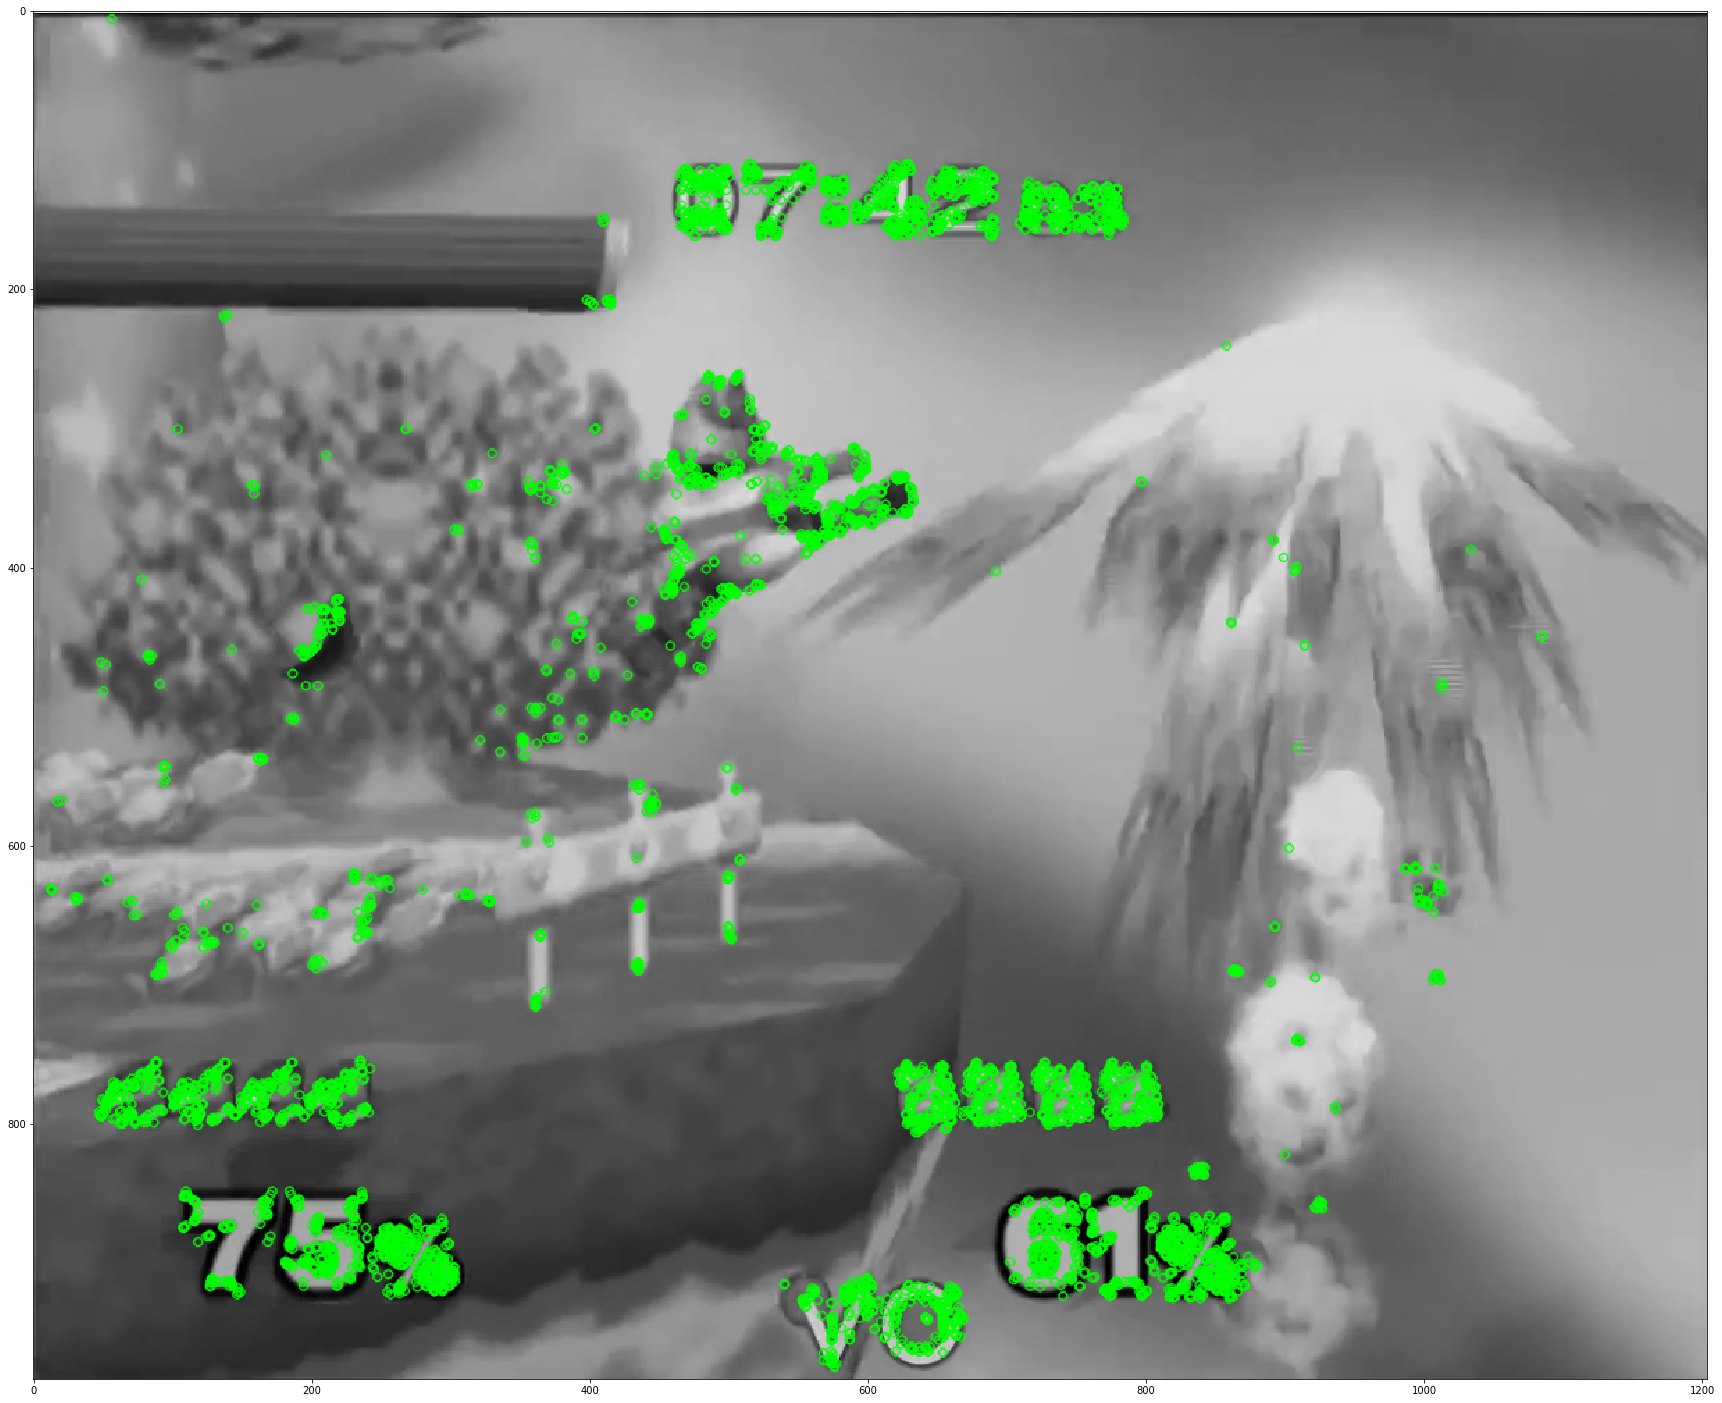

In [423]:
plt.figure(figsize=(30,30))
plt.imshow(cv2.drawKeypoints(img2, kp2_orb, None, color=(0,255,0), flags=0)); plt.show()

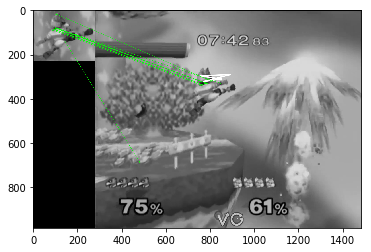

In [424]:
img_flann_orb, is_match = flann(6, (img1, kp1_orb, des1_orb), (img2, kp2_orb, des2_orb))
if is_match:
    plt.imshow(img_flann_orb); plt.show()

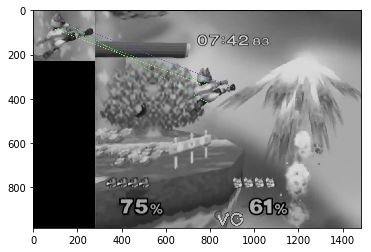

(<matplotlib.image.AxesImage at 0x7f35cd852080>, None)

In [428]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1_orb, des2_orb)

# Sort them in the order of their distance.
matches = sorted(matches, key=lambda x:x.distance)

# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1_orb,img2,kp2_orb,matches[:4], None, flags=2)

plt.imshow(img3),plt.show()

### Bulk Process

In [301]:
orb = cv2.ORB_create(5000)

img_bair = cv2.imread('nair_right.png', 0)
kp_bair, des_bair = orb.detectAndCompute(img_bair, None)

frames_dir = '../data/leffen_mango_tbh8/'
matches = []
for i, frame_name in enumerate(sorted(os.listdir(frames_dir))):
    if i % 100 == 0:
        print(i)
    img_frame = cv2.imread(frames_dir + frame_name)
    kp_frame, des_frame = orb.detectAndCompute(img_frame, None)
    
    img_flann_orb, is_match = flann(6, (img_bair, kp_bair, des_bair), (img_frame, kp_frame, des_frame), quiet=True)
    matches.append((frame_name, is_match))

0
100
200
300
400
500
600
700
800
900
1000
1100


In [302]:
list(filter(lambda x: x[1], matches))

[('image-000515.png', True),
 ('image-000516.png', True),
 ('image-000517.png', True),
 ('image-000518.png', True),
 ('image-000521.png', True),
 ('image-000522.png', True),
 ('image-000523.png', True),
 ('image-000524.png', True),
 ('image-000525.png', True),
 ('image-000526.png', True)]

### MSER

In [444]:
mser = cv2.MSER_create(4)
# https://docs.opencv.org/3.4.2/d3/d28/classcv_1_1MSER.html

kp1_MSER = mser.detect(img1)
kp2_MSER = mser.detect(img2)


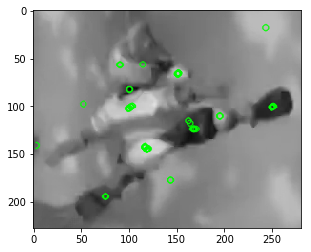

In [445]:
plt.imshow(cv2.drawKeypoints(img1, kp1_MSER, None, color=(0,255,0), flags=0)); plt.show()

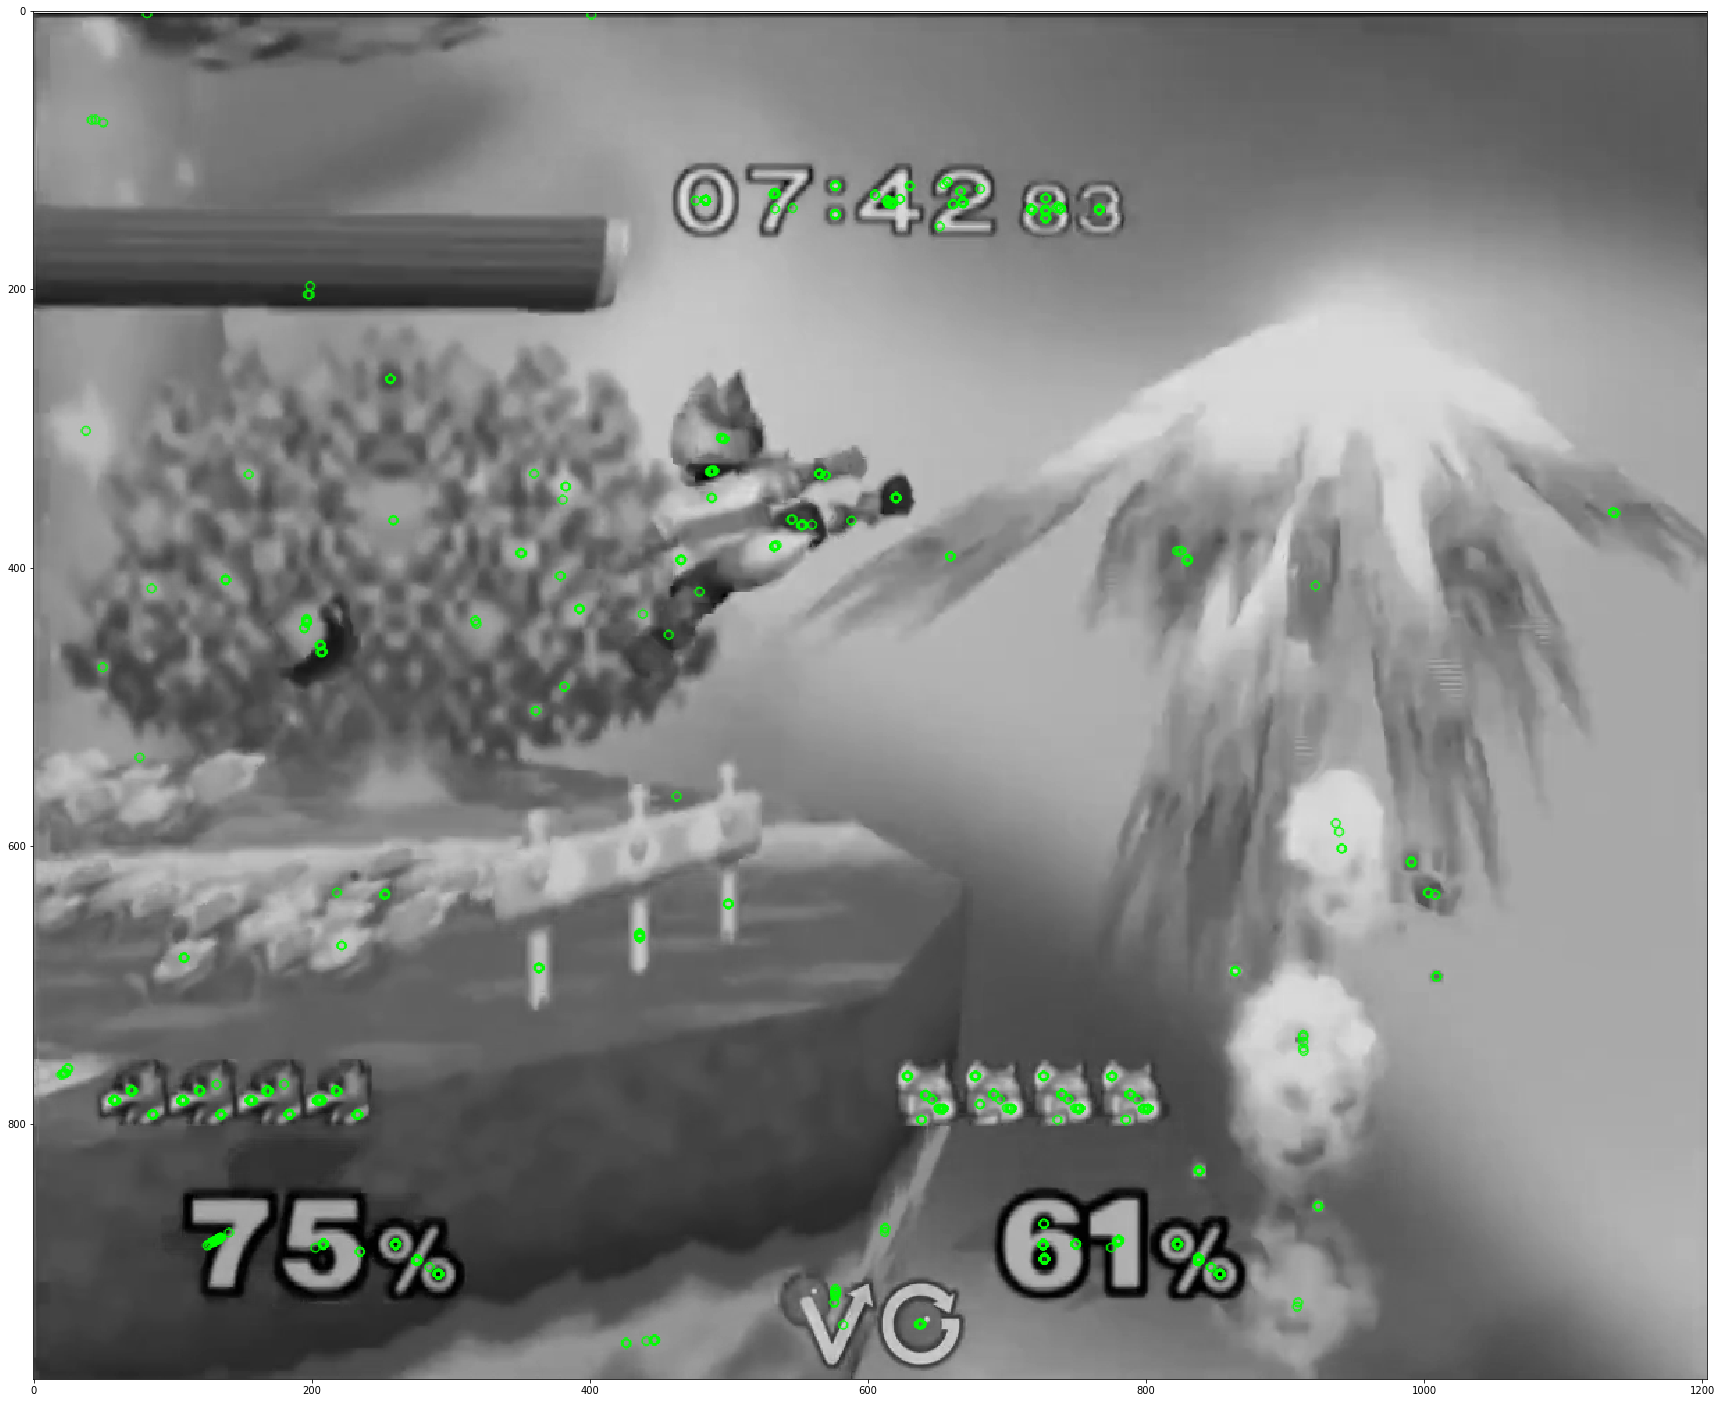

In [447]:
plt.figure(figsize=(30,30))
plt.imshow(cv2.drawKeypoints(img2, kp2_MSER, None, color=(0,255,0), flags=0)); plt.show()